## 我们主要是展示一下，如何用deep learning 去更好地做图片识别（分类）
---
### 今天我们要用到的是经典dataset [MNIST database](http://yann.lecun.com/exdb/mnist/) hand-written digit database.
### 这是一个手写字体的图片集，label 标的是0到9的阿拉伯数字！

步骤如下：

>1. 我们先load数据并看看它是怎么样的
2. 然后我们开始搭网络了
3. 训练
4. 评估是实际地预测我们的data


### 首先我们来看看我们要用的库

In [53]:
import torch # 这个是pytorch的包，用来搭建网络的！
import torch.nn as nn
import numpy as np # import 三包之一！！有木有 ！！

import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms# 这个是用来预处理图片那些数据的工具。torchvision 专门就是做计算机视觉的包。
#同理torchtext 就是专门作文本的一个工具。下期更新我就会使用torchtext 来做我们上次的text project

from torchvision import datasets ## 我们通过这个来import mnist dataset

import matplotlib.pyplot as plt# 画图 
%matplotlib inline

### 开始正式干活! 我们先load data

In [3]:
transform = transforms.ToTensor()# 这里我们调用的是torchvision 里面的transform工具，讲原来的数据变为tensor！！

#问题来了，我们原来的数据是怎么样的呢？下载了你可以自己去看看哦！！！！

train_data = datasets.MNIST(root='data',
                            train=True, #这是training!!
                            download=True, #我们要下载data
                            transform=transform #这里用了transform
                           )

test_data = datasets.MNIST(root='data',
                           train=False,#这是testing
                           download=True, #同上
                           transform=transform
                          )


0.8%

100.1%

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


7.9%5%

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


180.4%

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


### 下载好了我们来看看什么是tensor

In [11]:
train_data[0][0].size() # 这代表的是training data 第一个数据的 X 的形状！，这里是一个三维的tensor，28pixels * 28pixels

torch.Size([1, 28, 28])

In [12]:
train_data[0][1] # 对应的label就是 5，这张图片就是一张手写的 5 图片！

5

### 我们把处理好的tensor data，放到我们的dataloader工具里面，这样我们在run model 的时候，数据就能一批批地送给model去学习了。

In [43]:
batch_size = 20
num_workers = 0 # 这里0 就是一个 ！不并行处理
valid_size = .2


num_train = len(train_data) # n
indices = list(range(num_train)) # 0......n
np.random.seed(224)
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx) # the elements are index !!!
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler, 
                                           num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_data, #这个也是用training data
                                           batch_size=batch_size, 
                                           sampler=valid_sampler, # 哪些被选中的做validation
                                           num_workers=num_workers)

test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size=batch_size, 
                                          num_workers=num_workers)

### 也许这么讲还会是比较抽象，我一开始也是这样不懂，所以我们来把数字好好打印出来看看，就明白了

(20, 1, 28, 28)
(20, 28, 28)


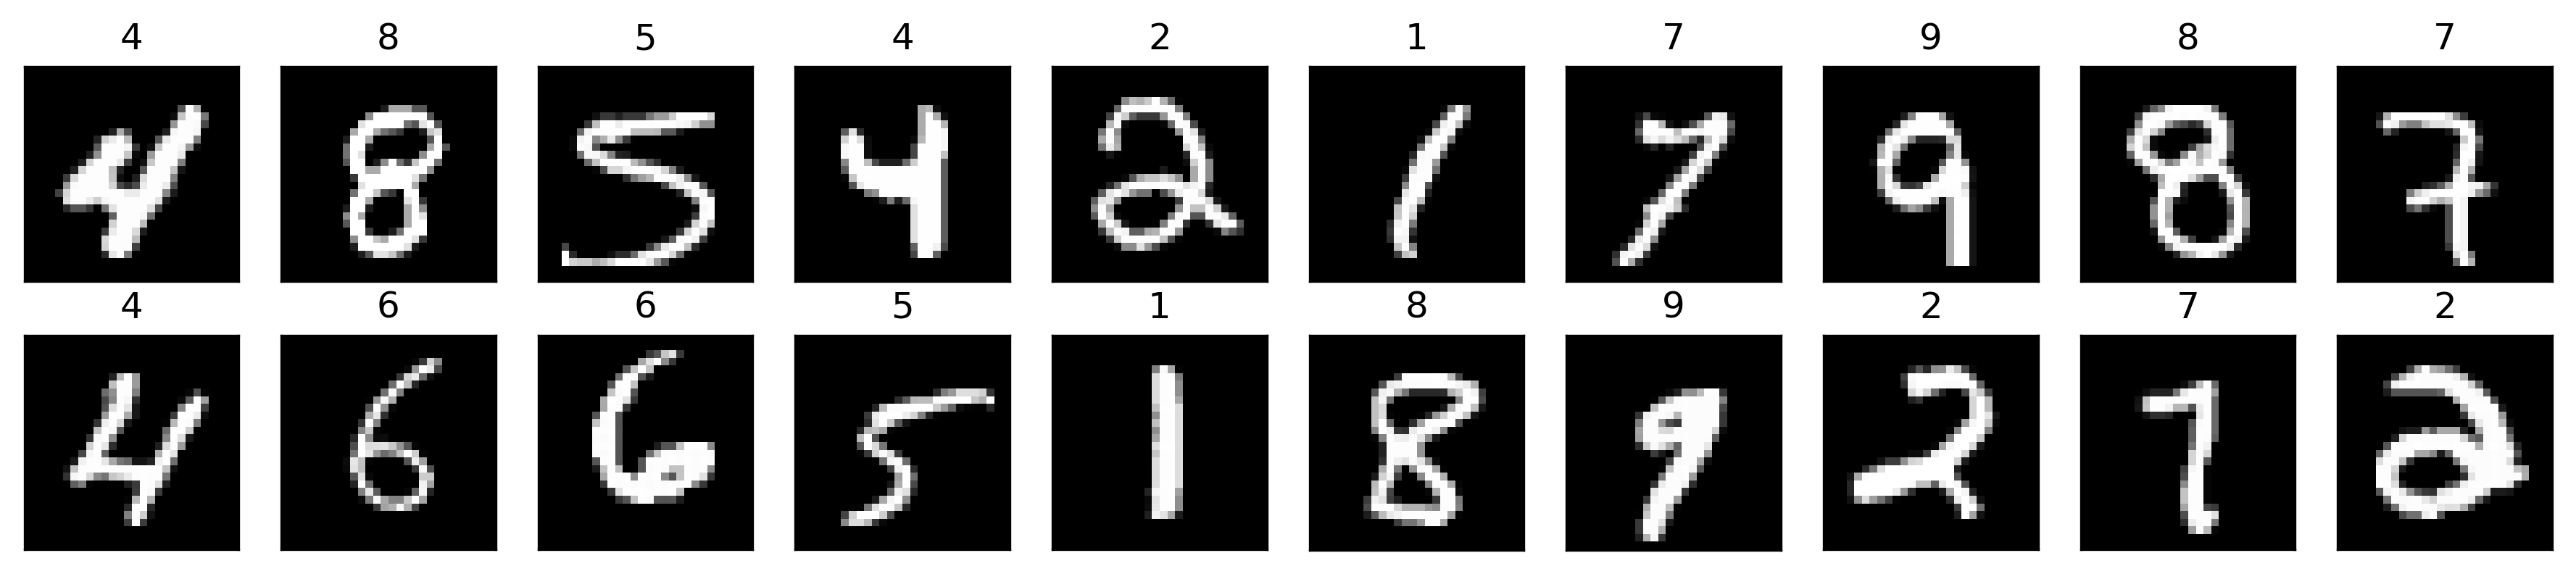

In [44]:
# 但是其实我们不能直接打印，因为matplitlib 其实不支持tensor 这种数据，于是我们还是好无聊的变回numpy！
# 我们先把数据处理一下，要展开我们的data

datashow = iter(train_loader) # 迭代器，我们可以一张张地打印。
pixels, labels = datashow.next() # next 的含义是一个个地迭代，这时候，pixels 就是我们的 tensor data，我们要把变回numpy
pixels = pixels.numpy() #就是这么简单的操作！
print(pixels.shape) # 这是我们可以看到 数据的维度还是原来的 20，1，28，28 这是个4维的
print(np.squeeze(pixels).shape) # sequeeze 就会减去中中间1的那个维度


#基本配置好了以后我们就开始作图了。
fig = plt.figure(figsize=(15,3),dpi=300) # 定义一下画布

for i in range(20): #我们作20张图,这里是一个batch的量 20张
    ax = fig.add_subplot(2,#两行
                         20/2,# 每行那就是 10个图片了
                         i+1,
                         xticks=[],
                         yticks=[], # 横纵坐标都抹去，毕竟我们要的就是图片本身
    )
    ax.imshow(np.squeeze(pixels[i]), # imshow 就是image show 出来！
              cmap='gray',
             )
    ax.set_title(str(labels[i].item()))# 这里label还是tensor的属性，所以我们要用item 这个method 读数字出来
                    
# 对的，我们的图片第一张是4,不是上面的5️⃣，我们打乱了

### 我们在单看一张图片，再细细研究

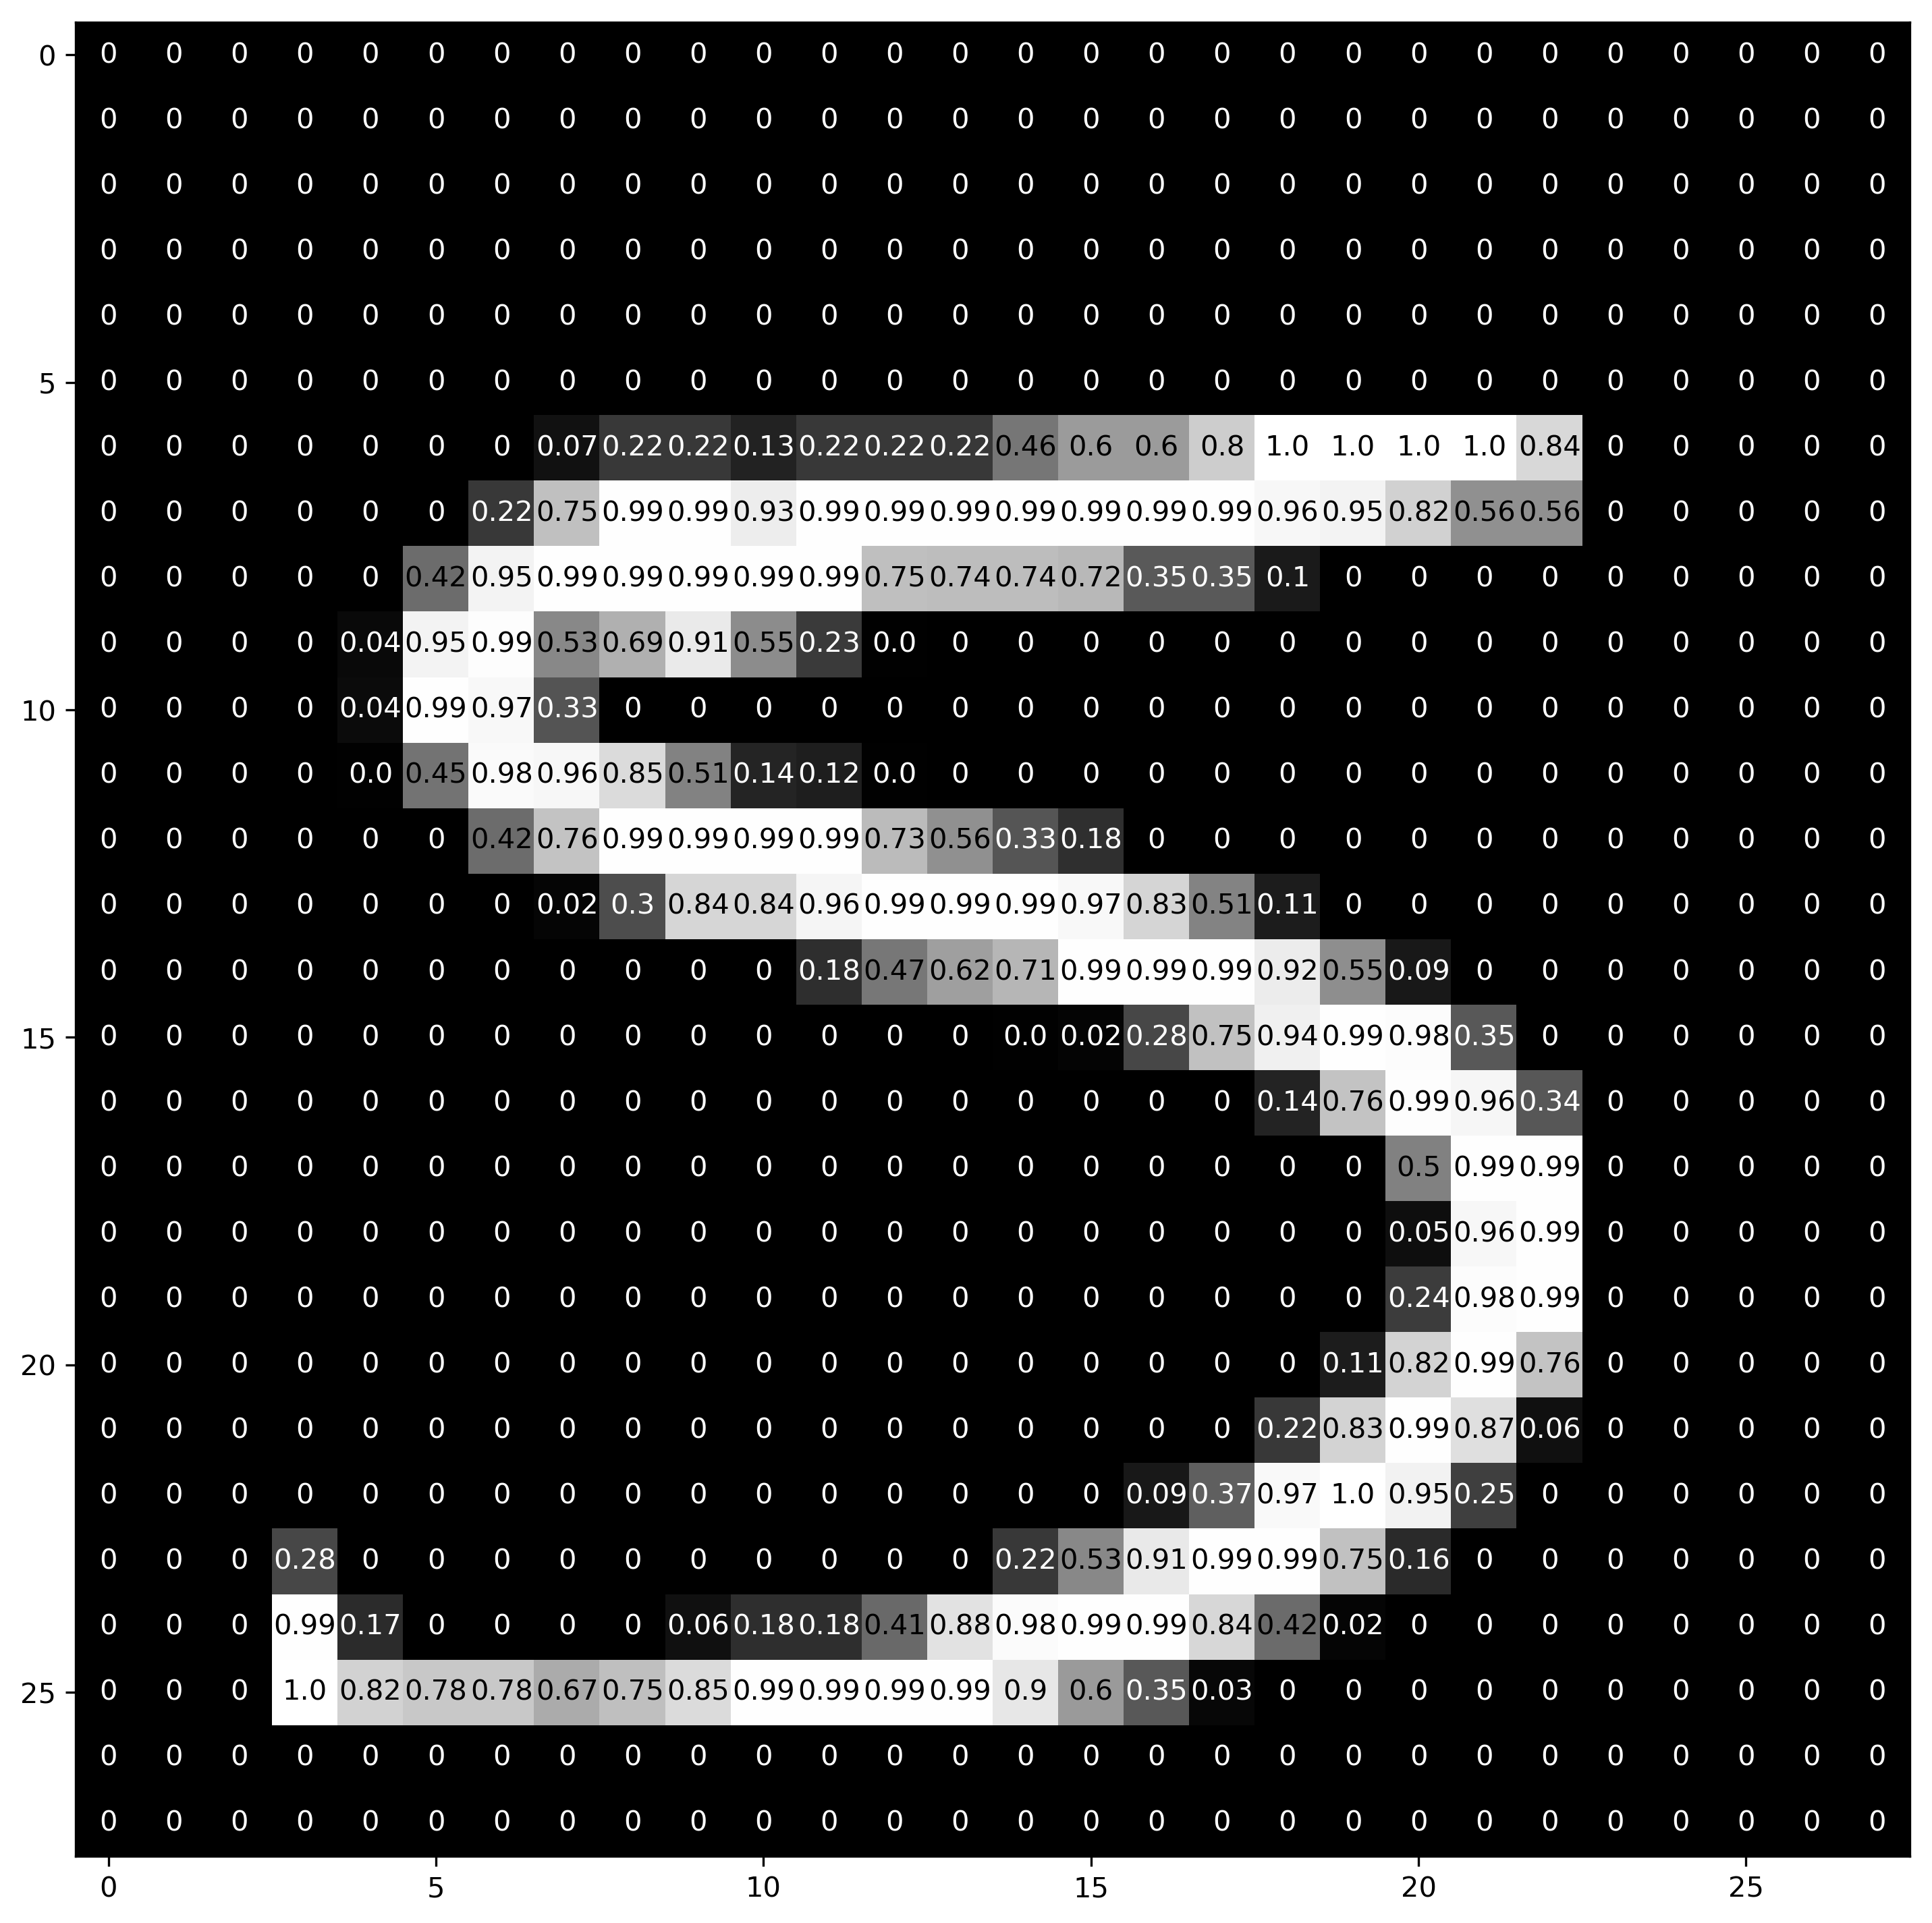

In [46]:
img = np.squeeze(pixels[2]) # 我们打印第三张，4 ！

fig = plt.figure(figsize = (12,12),dpi=300) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5

#下面的操作就是 打印上一些备注，我们展示出代表出阿拉伯图像的数字，分别是什么？
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0 # 取两位小数
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

### 希望通过上面，可以明白，计算机是怎么显示图片的。我们理解了这个以后就可以反过来然他来学习了
### 接下来我们来看看怎么用torch去搭建CNN model 

In [50]:
class CNN(nn.Module): # 我们使用nn.Module 去搭建，nn.Module 就是我们的建筑材料，
    def __init__(self): # 初始化
        super(CNN,self).__init__() # super就是我们继承原来的model，为什么我们要继承，我们要对元model进行修改，
        #这三行都是万年不变的操作
        
        #然后我们开始将混凝土，变为对应的建筑结构了，梁，柱子 。。。
        self.con1 = nn.Conv2d(in_channels = 1, # 如果是彩色，那三通道，这里就会是3，我们黑白图片就会是选1
                              out_channels = 16, # 我们用了16个不同的卷积去filter它，这里会产生16个结果，就是16张新的图片
                             kernel_size = 3, # 卷积的大小，3*3的矩阵
                             stride = 1, #步长，卷积每次滑动的pixel 大小
                             padding = 1, # 如果想要 con2d 出来的图片长宽没有变化, padding=(kernel_size-1)/2 当 stride=1
                             ) # 这里数据出来的size 是 ： 1，28，28 → 16，28，28.
        self.con2 = nn.Conv2d(16,32,3,1,1) # 这里直接写了，出来的data会是 32，28，28
        
        
        
        #可以看到，通过卷积，数据量变大了好多啊~，这样会不堪重负的，沃恩采取一个叫池化的工具，减少数据量，提升效率。
        self.pool = nn.MaxPool2d(2, 2) # 这里的2，2 分别是 kernel size 为2，然后步长为2. 这样的卷积，每次取经过的最大一个
        # 原来 28* 28 的图片，经过它以后，将 变为 14* 14 数据量变成原来的4份1.
        
        self.fc1 = nn.Linear(32 * 7 * 7, # 这是输入的大小，这个数字组合怎么来的呢❓
                             32) # 这里定义普通的神经网络，这里输出是：32
        # linear layer (32 -> 10)
        self.fc2 = nn.Linear(32, 10) # 接上，最后输出10个node，然后就是我们的 10个class了！
        
        #以上就是我们的造房子材料的过程！现在我们要考虑把它们，组合起来了
        
    def forward(self,x):# 这指的是我们的 一个batch 的data， 没处理前size 是 20，1，28，28
        x = self.pool(F.relu(self.con1(x))) # 过一个卷积，然后relu 做activation function，再接池化。
        # size： 最后输出是 batch 20，channel 16，像素 14，像素 14，
        x = self.pool(F.relu(self.con2(x)))
        # 这个 size 就会是 20，32，7，7 。ps： relu不改变size的哈
        
        x = x.view(-1, 32 * 7 * 7) # 这里view 就是 reshape 把它们变平，变成一个长条，塞到我们的普通神经网络里面
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x # 最后输出size 20，10
    
        
model = CNN()
print(model)  #看看我们的model    
    

CNN(
  (con1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (con2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


In [51]:
criterion = nn.CrossEntropyLoss() #分类都用这个loss ，这个评价标准

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(),lr = 0.001) #这里用sgd 这个优化器，改变我们的parameter 就是我们说的学习方式


### 原来我们花了那么多时间，现在总算是要去训练了

In [54]:
EPOCH = 50 # 这个参数的意思是，我们要完完整整地loop多少次whole data set

valid_loss_min = np.Inf # 这里会将我们的loss 一开始设成非常小的数字，多少可以打印出来看看

for epoch in range(EPOCH):

    train_loss = 0.0 # 我们在每个epoch 都会清零数据，
    valid_loss = 0.0
    
    ###################
    # 开始训练~ #@@@@@@@
    ###################
    model.train() # 这里是一个好习惯，将model 变为training model
    
    for data, target in train_loader: # 将我们打包好的batch data 来loop了
        
        
        optimizer.zero_grad() # 确保每次反向传播前，optimizer都是干净的！
        
        output = model(data) # 前向传播出一次结果，根据batch datas

        loss = criterion(output, target) # 算出误差
        
        loss.backward() # 反向传播 
       
        optimizer.step() # 根据方向传播改参数 

        train_loss += loss.item()*data.size(0) # 我们更新我们的这一个eopch 的loss
        
    ######################    
    # validate the model #
    ######################
    model.eval() # 衡量model 的好坏！
    
    for data, target in valid_loader:
        
        output = model(data)
        
        loss = criterion(output, target)
      
        valid_loss += loss.item()*data.size(0)  # 注意衡量是没有调参的哦，不会改变参数

        
    #注意缩进，整体量化loss    
    train_loss = train_loss/len(train_loader.sampler) # 这时候求平均
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss,
        valid_loss
        )) # 打印出来
    
    # 今天所学的trade off，但是我们不停止训练，万一还有更好的呢？
    #所以我们的操作是存下model 参数.并继续练！！！！！
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'Alexmodel.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.297552 	Validation Loss: 2.284449
Validation loss decreased (inf --> 2.284449).  Saving model ...
Epoch: 2 	Training Loss: 2.247410 	Validation Loss: 2.174416
Validation loss decreased (2.284449 --> 2.174416).  Saving model ...
Epoch: 3 	Training Loss: 1.627758 	Validation Loss: 0.776149
Validation loss decreased (2.174416 --> 0.776149).  Saving model ...
Epoch: 4 	Training Loss: 0.551298 	Validation Loss: 0.438775
Validation loss decreased (0.776149 --> 0.438775).  Saving model ...
Epoch: 5 	Training Loss: 0.392988 	Validation Loss: 0.364172
Validation loss decreased (0.438775 --> 0.364172).  Saving model ...
Epoch: 6 	Training Loss: 0.336283 	Validation Loss: 0.316807
Validation loss decreased (0.364172 --> 0.316807).  Saving model ...
Epoch: 7 	Training Loss: 0.301071 	Validation Loss: 0.281636
Validation loss decreased (0.316807 --> 0.281636).  Saving model ...
Epoch: 8 	Training Loss: 0.273350 	Validation Loss: 0.254579
Validation loss decreased (0.28163

### 从新读取我们的model

In [55]:
model.load_state_dict(torch.load('Alexmodel.pt'))

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [56]:
# 我们来看看我们这个model 有什么惊人的成绩， 经过50次迭代以后 ！
test_loss = 0.0
class_correct = list(0. for i in range(10)) # 我们定义一个长度为10 的list 存下我们的数据，这是for 正确的
class_total = list(0. for i in range(10)) # 这个是我们做出的total 的结果

model.eval() # 开启评价模式 

for data, target in test_loader: 
    # 换汤不换药 
    output = model(data)

    loss = criterion(output, target)

    test_loss += loss.item()*data.size(0) # 这里都是算我们的loss ，补充一下，size(0)就是我们的第一个维度，batch size

    
    _, pred = torch.max(output, 1) # 我们这个max 会返回，最大值和她所在的位置
    # pred 代表的就是哪一个node，就是我们最终选的数字是啥！
    
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    
    # 每一个结果，照着10个class 一个个看
    for i in range(len(target)): 
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# 跳出循环后，算平均的loss score ，可以和我们的 training比比啊~
test_loss = test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

#看每一个分类的结果!
for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), # 对应的阿拉伯数字 
            100 * class_correct[i] / class_total[i], # 对应的做出的选择然后是对的！
            np.sum(class_correct[i]), np.sum(class_total[i]))) # 打印选择的次数啥啥的 
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i])) #

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total), # 这里total 就是accuracy ！！ 请问上面的是什么指标呢，每个class？
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.054026

Test Accuracy of     0: 99% (975/980)
Test Accuracy of     1: 99% (1124/1135)
Test Accuracy of     2: 98% (1015/1032)
Test Accuracy of     3: 98% (995/1010)
Test Accuracy of     4: 98% (969/982)
Test Accuracy of     5: 97% (870/892)
Test Accuracy of     6: 98% (940/958)
Test Accuracy of     7: 97% (1003/1028)
Test Accuracy of     8: 97% (948/974)
Test Accuracy of     9: 96% (975/1009)

Test Accuracy (Overall): 98% (9814/10000)


### benchmark : 就普通的neural net work ！！！，这个CNN 这的不错哦

Test Loss: 0.166320

Test Accuracy of     0: 98% (964/980)

Test Accuracy of     1: 98% (1116/1135)

Test Accuracy of     2: 94% (972/1032)

Test Accuracy of     3: 94% (957/1010)

Test Accuracy of     4: 95% (938/982)

Test Accuracy of     5: 91% (820/892)

Test Accuracy of     6: 96% (921/958)

Test Accuracy of     7: 94% (972/1028)

Test Accuracy of     8: 93% (907/974)

Test Accuracy of     9: 93% (940/1009)

Test Accuracy (Overall): 95% (9507/10000)

### 最后可视化看看结果

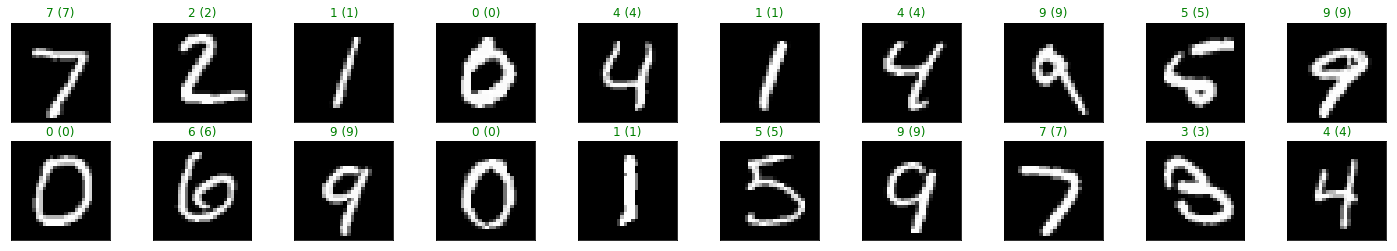

In [57]:

dataiter = iter(test_loader)
pixels, labels = dataiter.next()

# 看prediction
output = model(pixels)
# 转成哪个class
_, preds = torch.max(output, 1)
# 变numpy 才能打印啊~
images = pixels.numpy()

# 将一整个batch 的来打印
fig = plt.figure(figsize=(25, 4))
for i in range(20):
    ax = fig.add_subplot(2, 20/2, i+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[i].item()), str(labels[i].item())),
                 color=("green" if preds[i]==labels[i] else "red")) # 如果对了，就是绿字，如果错了就是红字！！！

### 全对✔️~